**使用VGG模型进行图像分类**

**一、数据预处理**

In [1]:
from frame_special import *
import numpy as np
import torchinfo

In [2]:
# 加载原始数据
train_arrays,train_labels = load_data()
test_arrays = load_test()

Load test data: 100%|██████████| 300000/300000 [00:30<00:00, 9990.34it/s] 


In [3]:
# 构造训练数据迭代器
batch_size = 64
train_dataset = TrainDataset(train_arrays,train_labels)
train_iter = data.DataLoader(train_dataset,batch_size,shuffle = True)

load 50000 images!


In [4]:
# 构造测试数据迭代器
test_dataset = TestDataset(test_arrays)
test_iter = data.DataLoader(test_dataset,batch_size,shuffle = False)

load 300000 images!


**二，VGG网络搭建**

In [5]:
def vgg_block(num_convs,in_channels,out_channels) -> nn.Sequential:
    """单个vgg块的生成"""
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels,out_channels,
                                kernel_size = 3,padding = 1)) # 保持宽高
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size = 2,stride = 2)) # 分辨率减半
    return nn.Sequential(*layers)

In [6]:
def vgg(conv_arch,in_H = 32,in_W = 32,class_nums = 10):
    """我的vgg网络，VGG-11加上一个softmax，处理分类问题"""
    conv_blks = []
    in_channels = 3     #初始为rgb三通道
    for num_convs,out_channels in conv_arch:
        conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
        in_channels = out_channels
        in_H = int(in_H / 2)
        in_W = int(in_W / 2)
    return nn.Sequential(
        *conv_blks,nn.Flatten(),
        nn.Linear(out_channels * in_H * in_W,4096),nn.ReLU(),nn.Dropout(0.5),
        nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(0.5),
        nn.Linear(4096,class_nums),nn.Softmax(dim = 1)
                         )

In [7]:
conv_arch = ((1,64),(1,128),(2,256),(2,512),(2,512))
object_map = get_map()
net = vgg(conv_arch)

In [8]:
# 构造输入，测试模型
input = torch.rand((1,3,32,32))
torchinfo.summary(net,input.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-3                    [1, 64, 16, 16]           --
├─Sequential: 1-2                        [1, 128, 8, 8]            --
│    └─Conv2d: 2-4                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-5                         [1, 128, 16, 16]          --
│    └─MaxPool2d: 2-6                    [1, 128, 8, 8]            --
├─Sequential: 1-3                        [1, 256, 4, 4]            --
│    └─Conv2d: 2-7                       [1, 256, 8, 8]            295,168
│    └─ReLU: 2-8                         [1, 256, 8, 8]            --
│    └─Conv2d: 2-9                       [1, 256, 8, 8]            590,08

**三、模型训练**

In [9]:
# 定义超参数
num_epochs = 50
lr = 3e-5

# 损失函数
loss_fn = nn.CrossEntropyLoss()

In [10]:

loss_plt = train(net,train_iter,lr,num_epochs,loss_fn)

Epoch [50/50]: 100%|██████████| 782/782 [00:14<00:00, 53.98it/s, LOSS=0.0247]


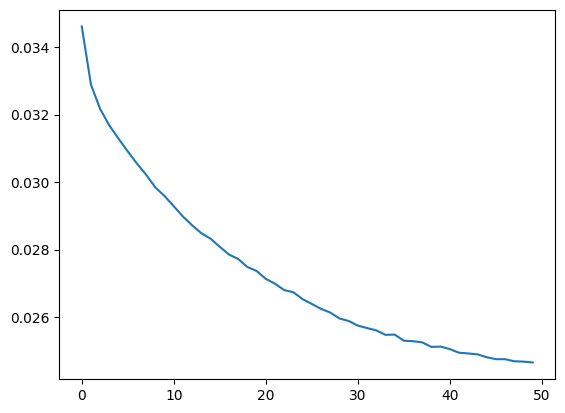

In [11]:
# 训练损失展示
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_plt)),loss_plt)
plt.show()

In [12]:
# 保存模型
torch.save(net,"models/vgg11-2.pt")
print(f"model save successfully!")

model save successfully!


**四、模型评估**

In [13]:
def count_accurancy(net,train_iter):
    """训练集上准确率测试"""
    device = try_gpu(i = 0)
    net.eval()
    net.to(device)
    total_nums = 0
    ans = 0
    loop = tqdm(train_iter,total = len(train_iter),desc = "Eval")
    for X,Y in loop:
        total_nums += X.shape[0]
        X = X.to(device)
        Y = Y.to(device).argmax(dim = 1)
        # print(X.shape,Y.shape)
        y_pred = net(X).argmax(dim = 1)
        # print(y_pred.shape)
        ans += (y_pred == Y).sum().item()
    return ans / total_nums

In [14]:
net = torch.load("models/vgg11-2.pt",weights_only = False)
acc = count_accurancy(net,train_iter)
print(acc)

Eval: 100%|██████████| 782/782 [00:05<00:00, 142.56it/s]

0.89026


In [15]:
# 在验证集上测试
predict(net,test_iter,train_dataset.idx2obj)

Predict: 100%|██████████| 4688/4688 [00:18<00:00, 247.52it/s]
